## Calculate bolometric corrections for the U, B and V bands in the Johnson-Cousins photometric system for 3 to 4 main-sequence (MS, luminosity class V) stars of different spectral classes  using their Kurucz theoretical spectra

Take the Kurucz theoretical spectra from http://svo2.cab.inta-csic.es/theory/newov/index.php,
the UBVRI response functions from http://www.aip.de/en/research/facilities/stella/instruments/data/johnson-ubvri-filter-curves, and parameters (${\cal M}/{\cal M}_\odot$, $R/R_\odot$ and $\log_{10}(L/L_\odot)$) of MS stars (V dwarfs) from internet, e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt. Assume that [Fe/H]=$0$ for all MS stars, except for Vega that has [Fe/H]=$-0.5$, $T_\mathrm{eff}=9550$ K, $\log_{10}g=3.95$ (cm/s$^2$) and $(R/d)^2=6.247\times 10^{-17}$.

In [399]:
import numpy as np
import matplotlib.pyplot as plt

# physical constants
import scipy.constants as sc

# astronomical constants
from astropy import constants as ac

from scipy.integrate import simps
from scipy import interpolate

fsize=16
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'

# the following commands allow to produce a nice pdf version of the notebook with figures
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/tmp/ipykernel_62/754875480.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [400]:
# minimum and maximum wave lengths in Angstroms used in plots
wl_min = 3000. 
wl_max = 10000. 

A bolometric correction in a photometric band A is

$$
BC_\mathrm{A} = 4.75 - 2.5\log_{10}\left[\frac{4\pi (10\mathrm{pc})^2\sigma T_\mathrm{eff}^4}{L_\odot}\right]
+ 2.5\log_{10}\left[\frac{\int_{\lambda_1}^{\lambda_2} F_\lambda S_\lambda d\lambda}{\int_{\lambda_1}^{\lambda_2} f^{0}_{\lambda} S_\lambda d\lambda}\right] - m^0_\mathrm{A},
$$

where $S_\lambda$ is a photometric-band response function, $F_\lambda$ is the intrinsic (at its surface) monochromatic flux from the star, $f^{0}_\lambda$ is the flux from a standard star (Vega) measured at the top of Earth's atmosphere and $m^{0}_\mathrm{A}$ is its apparent magnitude (zero for Vega).  

Therefore, we have to first calculate $\int_{\lambda_1}^{\lambda_2} f^{0}_{\lambda} S_\lambda d\lambda$
for Vega. A value of this integral will be assigned to res_0.

### NOTE: delete all header and comment lines in your saved text files with spectra and response functions. The read operators below assume that these files contain only numerical data !!!

### Also, pay attention to my naming of the spectra files and to the name of the directory in which they are saved. Change these, if you wish!

# U-Band ("Vega", G7V, F3V, A4V)

**"Vega"**

In [401]:
# first, read in a Kurucz theoretical spectrum of a star that is as similar to Vega
# as possible from http://svo2.cab.inta-csic.es/theory/newov/index.php

star = 'vega' # almost, with the closest parameters
Teff = 9750 # 9500 # K

# parameters of the star (Vega is an A0V star), 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
M = 2.18 
R = 2.193 
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 1.58

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

lgg = 4.0 # cm/s**2
# [Fe/H] = -0.5
Rd2 = 6.247e-17 # the square of the radius to distance ratio for Vega

mA0 = 0. # for Vega in the Johnson-Cousins system

# these are the names of the directory and file with theoretical stellar spectra
file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)  # this parameter will be used later

n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

g = 124.29305353352956 kg / m2 and its value in SI is 124.29305353352956
lgg = 4.094446857552692 (cm/s**2)
Teff = 9678.482398917247 (K)


In [402]:
# now, read in the UBVRI response functions that can be downloaded 
# from http://www.aip.de/en/research/facilities/stella/instruments/data/johnson-ubvri-filter-curves

band = ['U', 'B', 'V', 'R', 'I']
col = ['c', 'b', 'y', 'r', 'm']
n_band = len(band)

wl_band = []
sl_band = []

for k in range(n_band):
    
    wl_band.append([])
    sl_band.append([])
    # these are the names of the directory and file with the response functions   
    file_band = open('./data/spectra/Bessel_'+band[k]+'-1.txt',"r")


    for line in file_band:
        data = line.split()
        wl_band[k].append(10.*float(data[0])) # multiplied by 10 to transform nm to A
        sl_band[k].append(float(data[1]))

    file_band.close()
    
    # reverse the band arrays, so that wl_band increases along with wl_theory
    wl_band[k][:] = wl_band[k][::-1]
    sl_band[k][:] = sl_band[k][::-1]

    # normalize response functions
    sl_max = max(sl_band[k][:])
    for i in range(len(sl_band[k][:])):
        sl_band[k][i] = sl_band[k][i]/sl_max

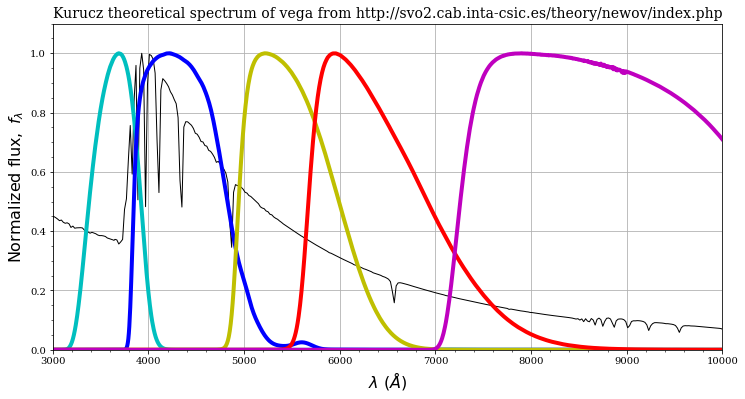

In [403]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
#plt.tight_layout()
plt.show()

In [404]:
# select a photometric band for which the bolometric correction will be calculated from
for kk in range(n_band):
    print ("k =", kk, "for band", band[kk])
    
k=0 # this is your selection
band_sel = band[k]
print ("The photometric band", band[k], "is selected")

k = 0 for band U
k = 1 for band B
k = 2 for band V
k = 3 for band R
k = 4 for band I
The photometric band U is selected


In [405]:
# isolate a range of wavelengths in which the selected response function is larger than sl_min
sl_min = 1e-4
wl_int = []
sl_int = []
for i in range(len(wl_band[k][:])):
    if sl_band[k][i] >= sl_min:
        wl_int.append(wl_band[k][i])
        sl_int.append(sl_band[k][i])
n_int = len(wl_int)

In [406]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

361 225
lambda_1 = 3110.0 , lambda_2 = 7580.0


In [407]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)
res_0 = res*Rd2 # this is the integral in the denominator in the above expression for BC_A

In [408]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

BC_Vega = BC

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star vega the bolometric correction in the band U is -0.21862831583519693


**G7V**

In [409]:
# provide here parameters of the star
star = 'G7V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 0.95
R = 0.927
Teff = 5550.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = -0.13

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A G7V star
g = 303.13198562425396 kg / m2 and its value in SI is 303.13198562425396
lgg = 4.481631764302987 (cm/s**2)
Teff = 5562.71376377907 (K)


In [410]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

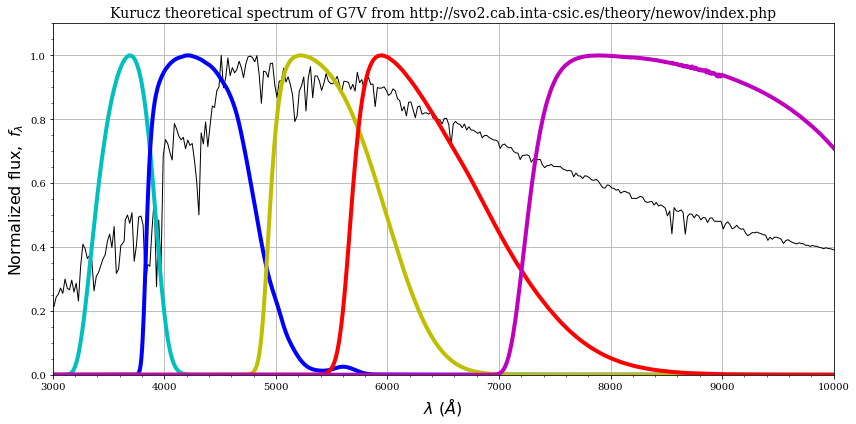

In [411]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [412]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

361 225
lambda_1 = 3110.0 , lambda_2 = 7580.0


In [413]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)

In [414]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star G7V the bolometric correction in the band U is -1.2427252793501822


**F3V**

In [415]:
# provide here parameters of the star
star = 'F3V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 1.44
R = 1.578
Teff = 6750.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 0.67

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A F3V star
g = 158.56820925985522 kg / m2 and its value in SI is 158.56820925985522
lgg = 4.20021612165158 (cm/s**2)
Teff = 6757.298141000172 (K)


In [416]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

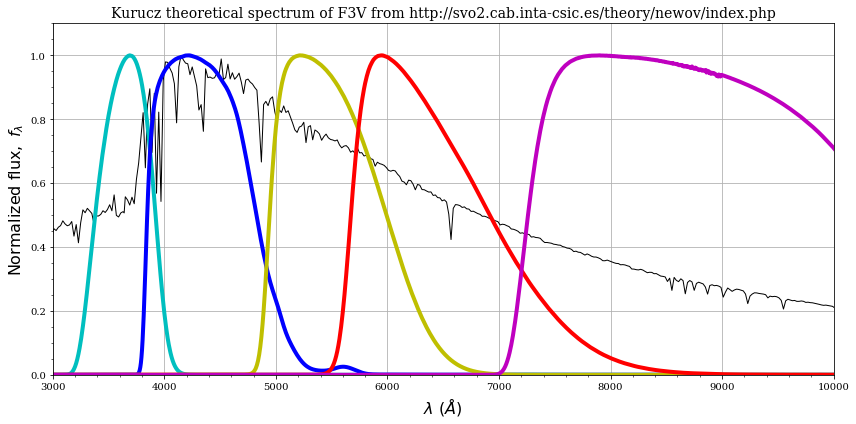

In [417]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [418]:
# select a part of the spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

361 225
lambda_1 = 3110.0 , lambda_2 = 7580.0


In [419]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
res = fl_max*simps(f_int, x=x_int)

In [420]:
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star F3V the bolometric correction in the band U is -0.4386539934525331


**A4V**

In [421]:
# provide here parameters of the star
star = 'A4V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 1.93
R = 1.794
Teff = 6750.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 1.13

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A A4V star
g = 164.4296221825539 kg / m2 and its value in SI is 164.4296221825539
lgg = 4.21598005889476 (cm/s**2)
Teff = 8258.769801220227 (K)


In [422]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

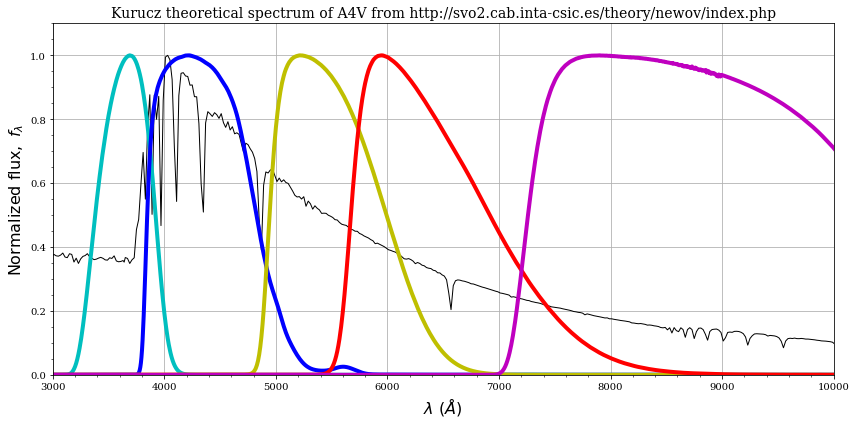

In [423]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [424]:
# select a part of the spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

361 225
lambda_1 = 3110.0 , lambda_2 = 7580.0


In [425]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
res = fl_max*simps(f_int, x=x_int)

In [426]:
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star A4V the bolometric correction in the band U is -0.2749221638415875


# B-Band ("Vega", A4V, F3V, G7V)

**Vega**

In [427]:
# first, read in a Kurucz theoretical spectrum of a star that is as similar to Vega
# as possible from http://svo2.cab.inta-csic.es/theory/newov/index.php

star = 'vega' # almost, with the closest parameters
Teff = 9750 # 9500 # K

# parameters of the star (Vega is an A0V star), 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
M = 2.18 
R = 2.193 
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 1.58

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

lgg = 4.0 # cm/s**2
# [Fe/H] = -0.5
Rd2 = 6.247e-17 # the square of the radius to distance ratio for Vega

mA0 = 0. # for Vega in the Johnson-Cousins system

# these are the names of the directory and file with theoretical stellar spectra
file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)  # this parameter will be used later

n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

g = 124.29305353352956 kg / m2 and its value in SI is 124.29305353352956
lgg = 4.094446857552692 (cm/s**2)
Teff = 9678.482398917247 (K)


In [428]:
# now, read in the UBVRI response functions that can be downloaded 
# from http://www.aip.de/en/research/facilities/stella/instruments/data/johnson-ubvri-filter-curves

band = ['U', 'B', 'V', 'R', 'I']
col = ['c', 'b', 'y', 'r', 'm']
n_band = len(band)

wl_band = []
sl_band = []

for k in range(n_band):
    
    wl_band.append([])
    sl_band.append([])
    # these are the names of the directory and file with the response functions   
    file_band = open('./data/spectra/Bessel_'+band[k]+'-1.txt',"r")


    for line in file_band:
        data = line.split()
        wl_band[k].append(10.*float(data[0])) # multiplied by 10 to transform nm to A
        sl_band[k].append(float(data[1]))

    file_band.close()
    
    # reverse the band arrays, so that wl_band increases along with wl_theory
    wl_band[k][:] = wl_band[k][::-1]
    sl_band[k][:] = sl_band[k][::-1]

    # normalize response functions
    sl_max = max(sl_band[k][:])
    for i in range(len(sl_band[k][:])):
        sl_band[k][i] = sl_band[k][i]/sl_max

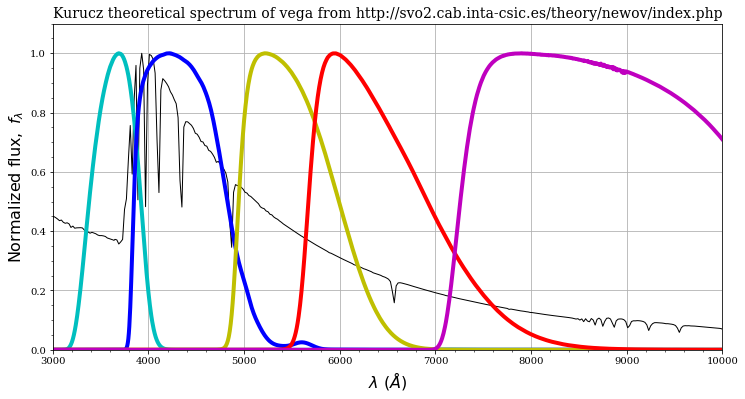

In [429]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
#plt.tight_layout()
plt.show()

In [430]:
# select a photometric band for which the bolometric correction will be calculated from
for kk in range(n_band):
    print ("k =", kk, "for band", band[kk])
    
k=1 # this is your selection
band_sel = band[k]
print ("The photometric band", band[k], "is selected")

k = 0 for band U
k = 1 for band B
k = 2 for band V
k = 3 for band R
k = 4 for band I
The photometric band B is selected


In [431]:
# isolate a range of wavelengths in which the selected response function is larger than sl_min
sl_min = 1e-4
wl_int = []
sl_int = []
for i in range(len(wl_band[k][:])):
    if sl_band[k][i] >= sl_min:
        wl_int.append(wl_band[k][i])
        sl_int.append(sl_band[k][i])
n_int = len(wl_int)

In [432]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

629 171
lambda_1 = 3735.0 , lambda_2 = 7160.0


In [433]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)
res_0 = res*Rd2 # this is the integral in the denominator in the above expression for BC_A

In [434]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

BC_Vega = BC

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star vega the bolometric correction in the band B is -0.21862831583519693


**G7V**

In [435]:
# provide here parameters of the star
star = 'G7V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 0.95
R = 0.927
Teff = 5550.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = -0.13

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A G7V star
g = 303.13198562425396 kg / m2 and its value in SI is 303.13198562425396
lgg = 4.481631764302987 (cm/s**2)
Teff = 5562.71376377907 (K)


In [436]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

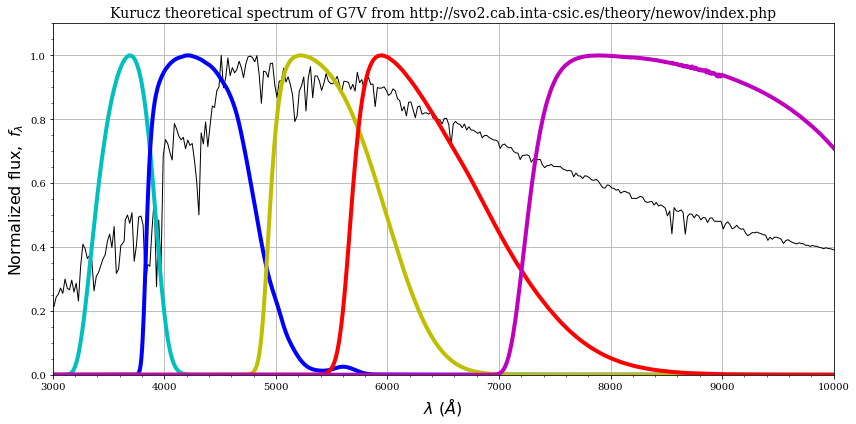

In [437]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [438]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

629 171
lambda_1 = 3735.0 , lambda_2 = 7160.0


In [439]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)

In [440]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star G7V the bolometric correction in the band B is -0.9893816079911417


**F3V**

In [441]:
# provide here parameters of the star
star = 'F3V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 1.44
R = 1.578
Teff = 6750.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 0.67

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A F3V star
g = 158.56820925985522 kg / m2 and its value in SI is 158.56820925985522
lgg = 4.20021612165158 (cm/s**2)
Teff = 6757.298141000172 (K)


In [442]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

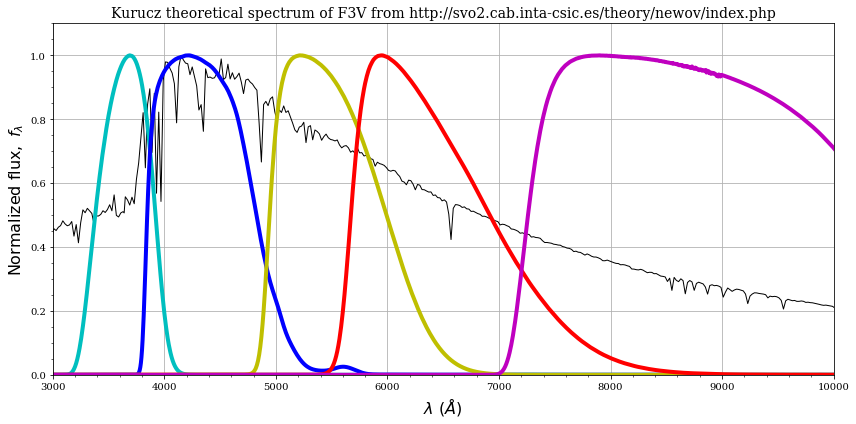

In [443]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [444]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

629 171
lambda_1 = 3735.0 , lambda_2 = 7160.0


In [445]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)

In [446]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star F3V the bolometric correction in the band B is -0.433491885019464


**A4V**

In [447]:
# provide here parameters of the star
star = 'A4V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 1.93
R = 1.794
Teff = 6750.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 1.13

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A A4V star
g = 164.4296221825539 kg / m2 and its value in SI is 164.4296221825539
lgg = 4.21598005889476 (cm/s**2)
Teff = 8258.769801220227 (K)


In [448]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

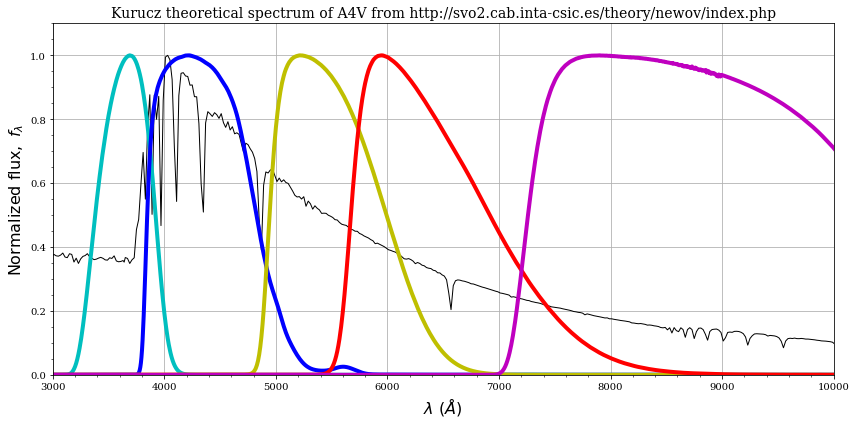

In [449]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [450]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

629 171
lambda_1 = 3735.0 , lambda_2 = 7160.0


In [451]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)

In [452]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star A4V the bolometric correction in the band B is -0.15783934269131095


# V-Band ("Vega", G7V, F3V, A4V)

**"Vega"**

In [453]:
# first, read in a Kurucz theoretical spectrum of a star that is as similar to Vega
# as possible from http://svo2.cab.inta-csic.es/theory/newov/index.php

star = 'vega' # almost, with the closest parameters
Teff = 9750 # 9500 # K

# parameters of the star (Vega is an A0V star), 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
M = 2.18 
R = 2.193 
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 1.58

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

lgg = 4.0 # cm/s**2
# [Fe/H] = -0.5
Rd2 = 6.247e-17 # the square of the radius to distance ratio for Vega

mA0 = 0. # for Vega in the Johnson-Cousins system

# these are the names of the directory and file with theoretical stellar spectra
file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)  # this parameter will be used later

n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

g = 124.29305353352956 kg / m2 and its value in SI is 124.29305353352956
lgg = 4.094446857552692 (cm/s**2)
Teff = 9678.482398917247 (K)


In [454]:
# now, read in the UBVRI response functions that can be downloaded 
# from http://www.aip.de/en/research/facilities/stella/instruments/data/johnson-ubvri-filter-curves

band = ['U', 'B', 'V', 'R', 'I']
col = ['c', 'b', 'y', 'r', 'm']
n_band = len(band)

wl_band = []
sl_band = []

for k in range(n_band):
    
    wl_band.append([])
    sl_band.append([])
    # these are the names of the directory and file with the response functions   
    file_band = open('./data/spectra/Bessel_'+band[k]+'-1.txt',"r")


    for line in file_band:
        data = line.split()
        wl_band[k].append(10.*float(data[0])) # multiplied by 10 to transform nm to A
        sl_band[k].append(float(data[1]))

    file_band.close()
    
    # reverse the band arrays, so that wl_band increases along with wl_theory
    wl_band[k][:] = wl_band[k][::-1]
    sl_band[k][:] = sl_band[k][::-1]

    # normalize response functions
    sl_max = max(sl_band[k][:])
    for i in range(len(sl_band[k][:])):
        sl_band[k][i] = sl_band[k][i]/sl_max

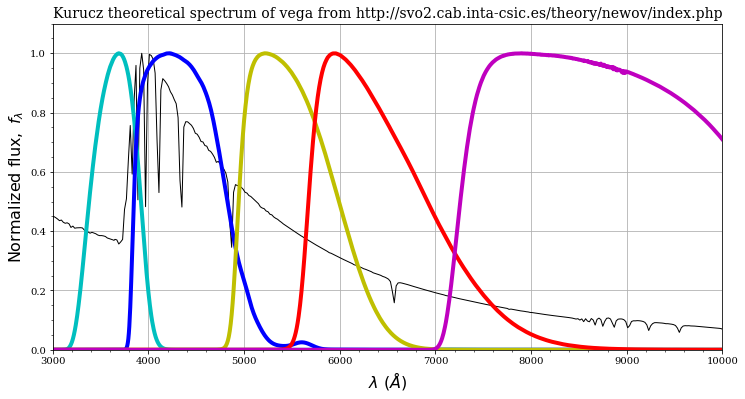

In [455]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
#plt.tight_layout()
plt.show()

In [456]:
# select a photometric band for which the bolometric correction will be calculated from
for kk in range(n_band):
    print ("k =", kk, "for band", band[kk])
    
k=2 # this is your selection
band_sel = band[k]
print ("The photometric band", band[k], "is selected")

k = 0 for band U
k = 1 for band B
k = 2 for band V
k = 3 for band R
k = 4 for band I
The photometric band V is selected


In [457]:
# isolate a range of wavelengths in which the selected response function is larger than sl_min
sl_min = 1e-4
wl_int = []
sl_int = []
for i in range(len(wl_band[k][:])):
    if sl_band[k][i] >= sl_min:
        wl_int.append(wl_band[k][i])
        sl_int.append(sl_band[k][i])
n_int = len(wl_int)

In [458]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

523 131
lambda_1 = 4670.0 , lambda_2 = 7285.0


In [459]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)
res_0 = res*Rd2 # this is the integral in the denominator in the above expression for BC_A

In [460]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

BC_Vega = BC

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star vega the bolometric correction in the band V is -0.21862831583519693


**G7V**

In [461]:
# provide here parameters of the star
star = 'G7V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 0.95
R = 0.927
Teff = 5550.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = -0.13

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A G7V star
g = 303.13198562425396 kg / m2 and its value in SI is 303.13198562425396
lgg = 4.481631764302987 (cm/s**2)
Teff = 5562.71376377907 (K)


In [462]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

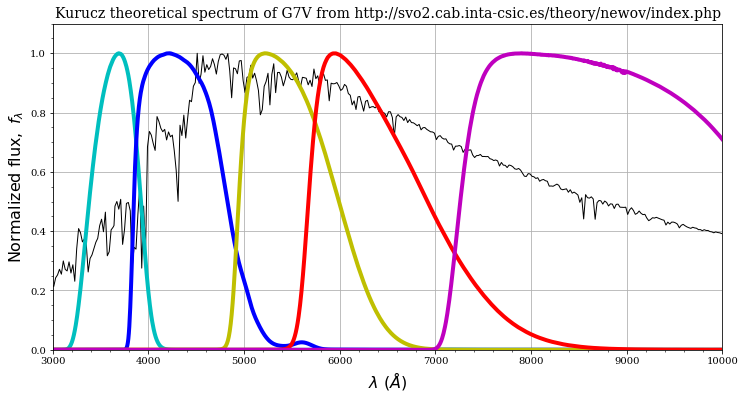

In [463]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
#plt.tight_layout()
plt.show()

In [464]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

523 131
lambda_1 = 4670.0 , lambda_2 = 7285.0


In [465]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)

In [466]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

BC_Vega = BC

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star G7V the bolometric correction in the band V is -0.18329642641341337


**F3V**

In [467]:
# provide here parameters of the star
star = 'F3V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 1.44
R = 1.578
Teff = 6750.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 0.67

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A F3V star
g = 158.56820925985522 kg / m2 and its value in SI is 158.56820925985522
lgg = 4.20021612165158 (cm/s**2)
Teff = 6757.298141000172 (K)


In [468]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

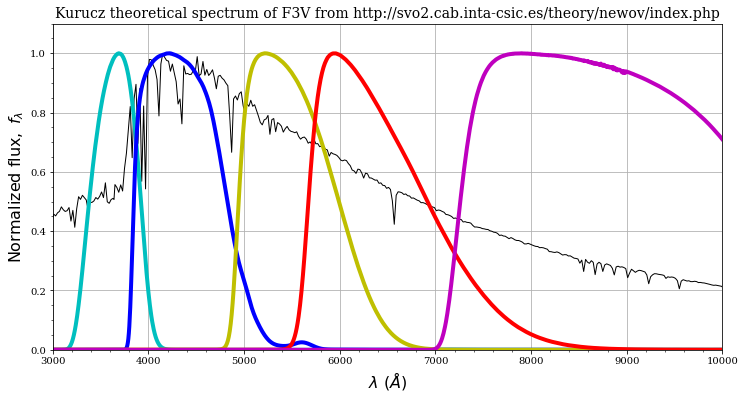

In [469]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
#plt.tight_layout()
plt.show()

In [470]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

523 131
lambda_1 = 4670.0 , lambda_2 = 7285.0


In [471]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)

In [472]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

BC_Vega = BC

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star F3V the bolometric correction in the band V is -0.010705276075270831


**A4V**

In [473]:
# provide here parameters of the star
star = 'A4V' # its spectral class
print ("A", star, "star")

# parameters of the star, 
# e.g. from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

M = 1.93
R = 1.794
Teff = 6750.
lgM = np.log10(M) 
lgR = np.log10(R) 
lgL = 1.13

#print ac.M_sun, ac.R_sun, ac.L_sun
g = sc.G*(10.**lgM*ac.M_sun)/(10.**lgR*ac.R_sun)**2 

# Note that in expressions one should use g.value, ac.L_sun.value, etc.

print ("g =", g, "and its value in SI is",g.value)
lgg = np.log10(1e2*g.value) # 1e2 transforms m/s**2 to cm/s**2, as used in model atmospheres
print ("lgg =", lgg, "(cm/s**2)") # for MS stars lgg should be around 4.
Teff = ((ac.L_sun.value/ac.R_sun.value**2)*10.**lgL/(4*sc.pi*(10.**lgR)**2*sc.sigma))**0.25
print ("Teff =", Teff, "(K)")

A A4V star
g = 164.4296221825539 kg / m2 and its value in SI is 164.4296221825539
lgg = 4.21598005889476 (cm/s**2)
Teff = 8258.769801220227 (K)


In [474]:
# read in a theoretical spectrum of the star
# take the Kurucz spectrum for the above specified parameters
# from http://svo2.cab.inta-csic.es/theory/newov/index.php

file_theory = open('./data/spectra/'+star+'theoryspectrum.txt',"r")

wl_theory = []
fl_theory = []

for line in file_theory:
    data = line.split()
    wl_theory.append(float(data[0]))
    fl_theory.append(float(data[1]))

file_theory.close()

# normalize the flux
fl_max = max(fl_theory)
n_theory = len(wl_theory)
for i in range(n_theory):
    fl_theory[i] = fl_theory[i]/fl_max

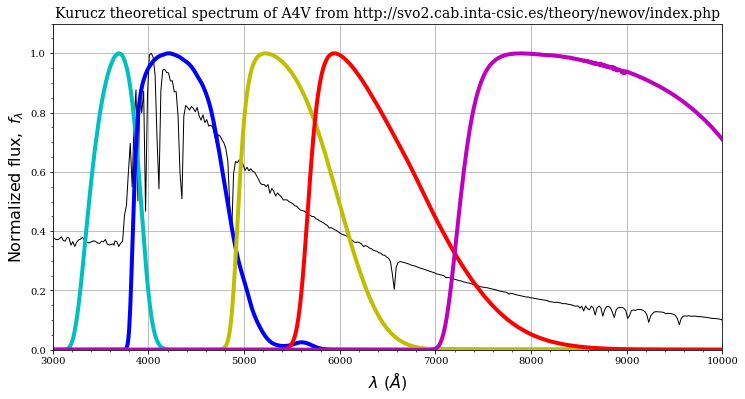

In [475]:
# plot the spectrum and response functions
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(12,6)

plt.plot(wl_theory,fl_theory,'k-',linewidth=1)    

for k in range(n_band):
    plt.plot(wl_band[k][:],sl_band[k][:],col[k],linewidth=4)

plt.xlim(wl_min,wl_max)
plt.ylim(0.,1.1)
plt.xlabel('$\lambda\ (\AA)$',fontsize=fsize)
plt.ylabel('$\mathrm{Normalized\ flux},\ f_\lambda$',fontsize=fsize)
plt.title('Kurucz theoretical spectrum of '+star+\
          ' from http://svo2.cab.inta-csic.es/theory/newov/index.php',fontsize=14)
plt.grid()
plt.minorticks_on()
#plt.tight_layout()
plt.show()

In [476]:
# select a part of the theoretical spectrum that overlaps with the isolated wavelength range
fl_int = []
x_int = []
wl_int_min = min(wl_int)
wl_int_max = max(wl_int)
for i in range(n_theory):
    if wl_theory[i] >= wl_int_min and wl_theory[i] <= wl_int_max:
        x_int.append(wl_theory[i])
        fl_int.append(fl_theory[i])
        
n_fl_int = len(x_int)
print (n_int, n_fl_int)
print ("lambda_1 =", wl_int[0], ", lambda_2 =", wl_int[-1])

523 131
lambda_1 = 4670.0 , lambda_2 = 7285.0


In [477]:
# prepare to interpolate the response function at the points in which the theoretical flux is provided
sl = interpolate.interp1d(wl_int,sl_int)

# this is the integrand that represents the convolution of the flux and response function
f_int = np.linspace(0,0,n_fl_int)
for i in range(n_fl_int):
    f_int[i] = fl_int[i]*sl(x_int[i])

# Simpson's rule is used here for integration
# after the integration don't forget to multiply by the flux normalization factor 
# fl_max that was found earlier
res = fl_max*simps(f_int, x=x_int)

In [478]:
# calculate BC for Vega and compare it with the value from the internet table
BC = 4.75-2.5*np.log10(4*sc.pi*(10*ac.pc.value)**2*ac.sigma_sb.value*Teff**4/ac.L_sun.value)+\
2.5*np.log10(res/res_0)-mA0

BC_Vega = BC

print ("For the star", star, "the bolometric correction in the band", band_sel, "is", BC)

For the star A4V the bolometric correction in the band V is -0.0033331306974275776
